In [440]:
import models
import numpy as np
import os
import sys
import config_vmc as cv_module
from numba import jit
from scipy.linalg import schur
from copy import deepcopy
@jit(nopython=True)
def from_linearized_index(index, L, n_orbitals, n_sublattices = 2):
    orbit = index % n_orbitals
    coord = index // n_orbitals
    sublattice = coord % n_sublattices
    coord = coord // n_sublattices

    x = coord // L
    y = coord % L
    return orbit, sublattice, x, y


@jit(nopython=True)
def to_linearized_index(x, y, sublattice, orbit, L, n_orbitals, n_sublattices = 2):
    return orbit + n_orbitals * (sublattice + n_sublattices * (y + x * L))

@jit(nopython=True)
def nearest_neighbor_hexagonal(r1, r2, L):
    if r1[1] == r2[1] and r1[0] == r2[0]:
        return True, 1
    if r1[1] == r2[1] and diff_modulo(r1[0], r2[0], L, 1):
        return True, 2
    if r1[0] == r2[0] and diff_modulo(r1[1], r2[1], L, 1):
        return True, 3
    return False, 0

@jit(nopython=True)
def next_nearest_neighbor_hexagonal(r1, r2, L):
    if r1[0] == r2[0] and diff_modulo(r1[1], r2[1], L, 1):
        return True, 1

    if diff_modulo(r1[0], r2[0], L, 1) and r1[1] == r2[1]:
        return True, 2

    if r1[0] == r2[0] and diff_modulo(r1[1], r2[1], L, -1):
        return True, 4

    if diff_modulo(r1[0], r2[0], L, -1) and r1[1] == r2[1]:
        return True, 5

    if diff_modulo(r1[0], r2[0], L, 1) and diff_modulo(r1[1], r2[1], L, -1):
        return True, 3

    if diff_modulo(r1[0], r2[0], L, -1) and diff_modulo(r1[1], r2[1], L, 1):
        return True, 6

    return False, -1


@jit(nopython=True)
def fifth_nearest_neighbor(r1, r2, L):
    if diff_modulo(r1[0], r2[0], L, 1) and diff_modulo(r1[1], r2[1], L, -2):
        return True
    if diff_modulo(r1[0], r2[0], L, -2) and diff_modulo(r1[1], r2[1], L, 1):
        return True
    if diff_modulo(r1[0], r2[0], L, 1) and diff_modulo(r1[1], r2[1], L, 1):
        return True
    return False


@jit(nopython=True)
def diff_modulo(x, y, L, d):
    if d >= 0:
        return (x - y + L) % L == d  # or (x - y + L) % L == L - d
    return (x - y + L) % L == L + d

@jit(nopython=True)
def _model_hex_2orb_Koshino(Ls):
    n_orbitals = 2
    n_sublattices = 2
    total_dof = Ls ** 2 * n_orbitals * n_sublattices * 2
    t1, t2, t5, t4 = 0.331, (-0.010 * 0. + 1.0j * 0.097), 0 * 0.119, 0 * 0.036


    K = np.zeros((total_dof // 2, total_dof // 2)) * 1.0j
    for first in range(total_dof // 2):
        for second in range(total_dof // 2):
            orbit1, sublattice1, x1, y1 = from_linearized_index(first, Ls, n_orbitals, n_sublattices)
            orbit2, sublattice2, x2, y2 = from_linearized_index(second, Ls, n_orbitals, n_sublattices)

            r1 = np.array([x1, y1])
            r2 = np.array([x2, y2])

            if orbit1 == orbit2 and nearest_neighbor_hexagonal(r1, r2, Ls)[0] and sublattice1 == 0 and sublattice2 == 1:
                K[first, second] = t1

            if orbit2 == orbit1 and fifth_nearest_neighbor(r1, r2, Ls) and sublattice2 == sublattice1:
                K[first, second] = np.real(t2)
            if orbit2 != orbit1 and fifth_nearest_neighbor(r1, r2, Ls) and sublattice2 == sublattice1:
                if orbit1 == 0 and orbit2 == 1:
                    K[first, second] = np.imag(t2)
                else:
                    K[first, second] = -np.imag(t2)

    K = K + K.conj().T
    return K


def import_config(filename: str):
    import importlib

    module_name, extension = os.path.splitext(os.path.basename(filename))
    module_dir = os.path.dirname(filename)
    if extension != ".py":
        raise ValueError(
            "Could not import the module from {!r}: not a Python source file.".format(
                filename
            )
        )
    if not os.path.exists(filename):
        raise ValueError(
            "Could not import the module from {!r}: no such file or directory".format(
                filename
            )
        )
    sys.path.insert(0, module_dir)
    module = importlib.import_module(module_name)
    sys.path.pop(0)
    return module

@jit(nopython=True)
def get_fft(N, n_bands):
    W = np.zeros((N ** 2, N ** 2), dtype=np.complex128)
    for kx in range(N):
        for ky in range(N):
            for x in range(N):
                for y in range(N):
                    W[x * N + y, kx * N + ky] = np.exp(2.0j * np.pi / N * kx * x + 2.0j * np.pi / N * ky * y)
    return np.kron(W, np.eye(n_bands)) / N / np.sqrt(n_bands)
L = 6

@jit(nopython=True)
def fermi(energy, beta):
    return 1 / (1. + np.exp(energy * beta))

@jit(nopython=True)
def lattice_to_physical(lattice):
    x = (lattice[0] + lattice[1]) * np.sqrt(3) / 2
    y = (lattice[0] - lattice[1]) / 2

    if lattice[2] == 1:
        x += 1. / np.sqrt(3)
    return np.array([x, y])

@jit(nopython=True)
def physical_to_lattice(physical):
    x, y = physical
    lattice = [0, 0, 0]
    if np.abs(int(np.rint(2 * x.real / np.sqrt(3))) - 2 * x.real / np.sqrt(3)) >= 1e-5:
        lattice[2] = 1
        x = x - 1. / np.sqrt(3)


    lattice[1] = int(np.rint((x.real - np.sqrt(3) * y.real) / np.sqrt(3)))
    lattice[0] = int(np.rint((x.real + np.sqrt(3) * y.real) / np.sqrt(3)))

    #print(physical, lattice, (x.real + np.sqrt(3) * y.real) / np.sqrt(3), (x.real - np.sqrt(3) * y.real) / np.sqrt(3))
    return np.array(lattice)

@jit(nopython=True)
def get_C3z_symmetry_map(Ls):
    n_orbitals = 2
    n_sublattices = 2
    total_dof = Ls ** 2 * n_orbitals * n_sublattices * 2

    mapping = np.zeros((total_dof // 2, total_dof // 2), dtype=np.complex128)  # trivial mapping
    rotation_matrix = np.array([[np.cos(2 * np.pi / 3.), np.sin(2 * np.pi / 3.)], \
                                [-np.sin(2 * np.pi / 3.), np.cos(2 * np.pi / 3.)]], dtype=np.complex128)
    rotation_matrix_orbital = np.array([[np.exp(-2.0j * np.pi / 3), 0], [0, np.exp(2.0j * np.pi / 3)]])

    for preindex in range(total_dof // 2):
        orbit_preimage, sublattice_preimage, x_preimage, y_preimage = \
            from_linearized_index(preindex, Ls, n_orbitals, n_sublattices)

        orbit_preimage_vector = np.zeros(n_orbitals, dtype=np.complex128); orbit_preimage_vector[orbit_preimage] = 1.
        r_preimage = lattice_to_physical([x_preimage, y_preimage, sublattice_preimage]).astype(np.complex128)

        orbit_image_vector = rotation_matrix_orbital.dot(orbit_preimage_vector) #np.einsum('ij,j->i', rotation_matrix_orbital, orbit_preimage_vector)

        r_image = rotation_matrix.dot(r_preimage)#np.einsum('ij,j->i', rotation_matrix, r_preimage)
        x_image, y_image, sublattice_image = physical_to_lattice(r_image)
        #print(r_preimage, '-->', r_image)
        # print(sublattice_preimage, x_preimage, y_preimage, '-->', sublattice_image, x_image, y_image)
        x_image = int(np.rint(x_image)) % Ls; y_image = int(np.rint(y_image)) % Ls
        
        for orbit_image in range(n_orbitals):
            coefficient = orbit_image_vector[orbit_image]
            index = to_linearized_index(x_image, y_image, sublattice_image, orbit_image, \
                                               Ls, n_orbitals, n_sublattices)
            mapping[preindex, index] += coefficient
                
    assert np.sum(np.abs(mapping.dot(mapping).dot(mapping) - np.eye(mapping.shape[0]))) < 1e-5  # C_3z^3 = I
    return mapping


@jit(nopython=True)
def get_Tx_symmetry_map(Ls):
    n_orbitals = 2
    n_sublattices = 2
    total_dof = Ls ** 2 * n_orbitals * n_sublattices * 2

    mapping = np.zeros((total_dof // 2, total_dof // 2), dtype=np.complex128)  # trivial mapping
    for preindex in range(total_dof // 2):
        orbit_preimage, sublattice_preimage, x_preimage, y_preimage = \
            from_linearized_index(preindex, Ls, n_orbitals, n_sublattices)

        orbit_preimage_vector = np.zeros(n_orbitals, dtype=np.complex128); orbit_preimage_vector[orbit_preimage] = 1.
        r_preimage = lattice_to_physical([x_preimage, y_preimage, sublattice_preimage]).astype(np.complex128)

        orbit_image_vector = orbit_preimage_vector

        r_image = r_preimage + np.array([np.sqrt(3), 1]) / 2. #rotation_matrix.dot(r_preimage)#np.einsum('ij,j->i', rotation_matrix, r_preimage)
        x_image, y_image, sublattice_image = physical_to_lattice(r_image)
        #print(r_preimage, '-->', r_image)
        # print(sublattice_preimage, x_preimage, y_preimage, '-->', sublattice_image, x_image, y_image)
        x_image = int(np.rint(x_image)) % Ls; y_image = int(np.rint(y_image)) % Ls
        
        for orbit_image in range(n_orbitals):
            coefficient = orbit_image_vector[orbit_image]
            index = to_linearized_index(x_image, y_image, sublattice_image, orbit_image, \
                                               Ls, n_orbitals, n_sublattices)
            mapping[preindex, index] += coefficient
                
    assert np.sum(np.abs(mapping.dot(mapping).dot(mapping).dot(mapping).dot(mapping).dot(mapping) - np.eye(mapping.shape[0]))) < 1e-5  # C_3z^3 = I
    return mapping

@jit(nopython=True)
def get_Ty_symmetry_map(Ls):
    n_orbitals = 2
    n_sublattices = 2
    total_dof = Ls ** 2 * n_orbitals * n_sublattices * 2

    mapping = np.zeros((total_dof // 2, total_dof // 2), dtype=np.complex128)  # trivial mapping
    for preindex in range(total_dof // 2):
        orbit_preimage, sublattice_preimage, x_preimage, y_preimage = \
            from_linearized_index(preindex, Ls, n_orbitals, n_sublattices)

        orbit_preimage_vector = np.zeros(n_orbitals, dtype=np.complex128); orbit_preimage_vector[orbit_preimage] = 1.
        r_preimage = lattice_to_physical([x_preimage, y_preimage, sublattice_preimage]).astype(np.complex128)

        orbit_image_vector = orbit_preimage_vector

        r_image = r_preimage + np.array([np.sqrt(3), -1]) / 2. #rotation_matrix.dot(r_preimage)#np.einsum('ij,j->i', rotation_matrix, r_preimage)
        x_image, y_image, sublattice_image = physical_to_lattice(r_image)
        #print(r_preimage, '-->', r_image)
        # print(sublattice_preimage, x_preimage, y_preimage, '-->', sublattice_image, x_image, y_image)
        x_image = int(np.rint(x_image)) % Ls; y_image = int(np.rint(y_image)) % Ls
        
        for orbit_image in range(n_orbitals):
            coefficient = orbit_image_vector[orbit_image]
            index = to_linearized_index(x_image, y_image, sublattice_image, orbit_image, \
                                               Ls, n_orbitals, n_sublattices)
            mapping[preindex, index] += coefficient
                
    assert np.sum(np.abs(mapping.dot(mapping).dot(mapping).dot(mapping).dot(mapping).dot(mapping) - np.eye(mapping.shape[0]))) < 1e-5  # C_3z^3 = I
    return mapping

In [441]:
mapping = get_C3z_symmetry_map(L)
Tx = get_Tx_symmetry_map(L)
Ty = get_Ty_symmetry_map(L)

In [442]:
Ls = L
K0 = _model_hex_2orb_Koshino(L)
U_xy_to_chiral = np.kron(np.eye(K0.shape[0] // 2), np.array([[1, 1], [-1.0j, +1.0j]]) / np.sqrt(2))

K0 = U_xy_to_chiral.conj().T.dot(K0).dot(U_xy_to_chiral)
assert np.isclose(np.dot(K0.conj().flatten(), mapping.dot(K0).dot(mapping.T.conj()).flatten()) / np.dot(K0.conj().flatten(), K0.flatten()), 1)
assert np.isclose(np.dot(K0.conj().flatten(), Tx.dot(K0).dot(Tx.T.conj()).flatten()) / np.dot(K0.conj().flatten(), K0.flatten()), 1)
assert np.isclose(np.dot(K0.conj().flatten(), Ty.dot(K0).dot(Ty.T.conj()).flatten()) / np.dot(K0.conj().flatten(), K0.flatten()), 1)
TRS = np.concatenate([np.array([2 * i + 1, 2 * i]) for i in range(K0.shape[0] // 2)])


K0_TRS = K0[TRS, :]
K0_TRS = K0_TRS[:, TRS].conj()

assert np.isclose(np.vdot(K0.flatten(), K0_TRS.flatten()) / np.dot(K0.conj().flatten(), K0.flatten()), 1.0)


K0_plus = K0[::2, :]
K0_plus = K0_plus[:, ::2]

K0_minus = K0[1::2, :]
K0_minus = K0_minus[:, 1::2]

assert np.allclose(np.linalg.eigh(K0_plus)[0], np.linalg.eigh(K0_minus)[0])

n_bands = 4
beta = 0.1
fft = get_fft(Ls, n_bands)

K0 = K0 - np.diag(np.diag(K0) * 0.  + 0.07375 + 0.00125 / 8. +  + 0.00125 / 64.)
energies = np.linalg.eigh(K0)[0]
print(energies)
### doing the FFT of K0 ###
K0_fft = fft.conj().T.dot(K0).dot(fft)

K0_fft_plus = K0_fft[::2, :]
K0_fft_plus = K0_fft_plus[:, ::2]

K0_fft_minus = K0_fft[1::2, :]
K0_fft_minus = K0_fft_minus[:, 1::2]

K0_check = K0_fft.copy()
for i in range(K0_check.shape[0] // n_bands):
    K0_check[i * n_bands:i * n_bands + n_bands,i * n_bands:i * n_bands + n_bands] = 0.0
assert np.isclose(np.sum(np.abs(K0_check)), 0.0)


A = np.zeros((L, L, n_bands, n_bands), dtype=np.complex128)
energies = np.zeros((L, L, n_bands), dtype=np.complex128)

energies_plus = np.zeros((L, L, n_bands // 2), dtype=np.complex128)
energies_minus = np.zeros((L, L, n_bands // 2), dtype=np.complex128)
for i in range(K0_check.shape[0] // n_bands):
    kx, ky = i % L, i // L
    mat = K0_fft[i * n_bands:i * n_bands + n_bands,i * n_bands:i * n_bands + n_bands]
    assert np.allclose(mat.conj().T, mat)
    
    
    A[kx, ky, ...] = np.linalg.eigh(mat)[1]
    
    nonch = 0
    for i in range(n_bands):
        for j in range(n_bands):
            if (i + j) % 2 == 1:
                nonch += np.abs(mat[i, j])
    print(nonch)
    assert np.isclose(nonch, 0.0)
    
    
    energies[kx, ky, ...] = np.linalg.eigh(mat)[0]
    energies_plus[kx, ky, ...] = np.linalg.eigh(K0_fft_plus[i * n_bands // 2:i * n_bands // 2 + n_bands // 2, i * n_bands // 2:i * n_bands // 2 + n_bands // 2])[0]
    energies_minus[kx, ky, ...] = np.linalg.eigh(K0_fft_minus[i * n_bands // 2:i * n_bands // 2 + n_bands // 2, i * n_bands // 2:i * n_bands // 2 + n_bands // 2])[0]

print(np.sort(energies.flatten()))
print(np.sort(energies_plus.flatten()), np.sort(energies_minus.flatten()))
print(np.sort(energies_plus.flatten()) - np.sort(energies_minus.flatten()))
assert np.allclose(np.sort(energies_plus.flatten()), np.sort(energies_minus.flatten()))
@jit(nopython=True)
def get_susc_zero(Ls, n_bands, A, A_plus_q, energies, energies_plus_q, omega, temp):
    chi = np.zeros((n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
    for kx in range(Ls):
        for ky in range(Ls):
            for alpha in range(n_bands):
                for beta in range(n_bands):
                    for p in range(n_bands):
                        for q in range(n_bands):
                            for s in range(n_bands):
                                for t in range(n_bands):
                                    chi[p, q, s, t] -= A[kx, ky, s, alpha] * \
                                               np.conj(A[kx, ky, p, alpha]) * \
                                                       A_plus_q[kx, ky, q, beta] * \
                                               np.conj(A_plus_q[kx, ky, t, beta]) / \
                                                (omega + energies_plus_q[kx, ky, beta] - energies[kx, ky, alpha] + 1e-10j) * \
                                                (fermi(energies_plus_q[kx, ky, beta], temp) - fermi(energies[kx, ky, alpha], temp))
                 
    return chi / n_bands / Ls ** 2 ## FIXME: factor?

susc_0 = np.zeros((L, L, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
for qx in range(Ls):
    for qy in range(Ls):
        A_plus_q = np.roll(A, shift = qx, axis=0)
        A_plus_q = np.roll(A_plus_q, shift = qy, axis=1)
    
        energies_plus_q = np.roll(energies, shift = qx, axis=0)
        energies_plus_q = np.roll(energies_plus_q, shift = qy, axis=1)
        susc_0[qx, qy, ...] = get_susc_zero(Ls, n_bands, A, A_plus_q, energies, energies_plus_q, 0., beta)
        
        for a in range(n_bands):
            for b in range(n_bands):
                for c in range(n_bands):
                    for d in range(n_bands):
                        if (a + c) % 2 != (b + d) % 2:
                            assert np.isclose(susc_0[qx, qy, a, b, c, d], 0.0)
        ## conserve valley quantum number
                        
susc_uniform = np.sum(susc_0[:, :, np.arange(n_bands), np.arange(n_bands), :, :], axis=2)
susc_uniform = np.sum(susc_uniform[:, :, np.arange(n_bands), np.arange(n_bands)], axis=-1).real
print(np.sum(np.abs(A.real)))

[-1.15126138 -1.15126138 -1.15126138 -1.15126138 -1.15126138 -1.15126138
 -1.11767839 -1.11767839 -1.11767839 -1.11767839 -1.11767839 -1.11767839
 -1.06692578 -1.06692578 -0.78166054 -0.78166054 -0.78166054 -0.78166054
 -0.78166054 -0.78166054 -0.73592578 -0.73592578 -0.73592578 -0.73592578
 -0.73592578 -0.73592578 -0.73592578 -0.73592578 -0.73592578 -0.73592578
 -0.73592578 -0.73592578 -0.57293471 -0.57293471 -0.57293471 -0.57293471
 -0.57293471 -0.57293471 -0.57293471 -0.57293471 -0.57293471 -0.57293471
 -0.57293471 -0.57293471 -0.40492578 -0.40492578 -0.40492578 -0.40492578
 -0.40492578 -0.40492578 -0.23691685 -0.23691685 -0.23691685 -0.23691685
 -0.23691685 -0.23691685 -0.23691685 -0.23691685 -0.23691685 -0.23691685
 -0.23691685 -0.23691685 -0.14320781 -0.14320781 -0.14320781 -0.14320781
 -0.14320781 -0.14320781 -0.07392578 -0.07392578 -0.07392578 -0.07392578
 -0.07392578 -0.07392578 -0.07392578 -0.07392578 -0.00464375 -0.00464375
 -0.00464375 -0.00464375 -0.00464375 -0.00464375  0

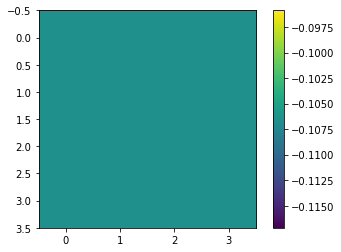

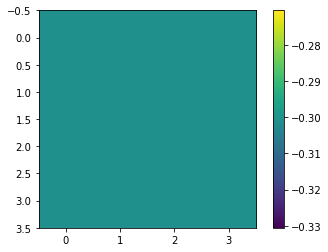

-4.808257127209721

In [439]:
import matplotlib.pyplot as plt
plt.imshow(energies_plus[..., 0].real, interpolation='nearest')
plt.colorbar()
plt.show()

import matplotlib.pyplot as plt
plt.imshow(energies_minus[..., 0].real, interpolation='nearest')
plt.colorbar()
plt.show()

np.sum(energies_minus[..., 0].real)

In [ ]:
Alat = np.array([[1, 0], [1. / 2., np.sqrt(3) / 2.]])
G = 2 * np.pi * np.array([[1, -1. / np.sqrt(3)], [0, 2 / np.sqrt(3)]])  # is this momentum compatible?

print(Alat.dot(G) /2 / np.pi)

def get_interaction(n_bands, qx, qy, U, J):
    U_total = np.zeros((2 * n_bands, 2 * n_bands, 2 * n_bands, 2 * n_bands), dtype=np.complex128)
    q_phys = (G[0] * qx + G[1] * qy) / L
    exp_q1 = np.exp(1.0j * np.dot(q_phys, Alat[0]))
    exp_q2 = np.exp(1.0j * np.dot(q_phys, Alat[1]))

    
    for band in range(4):
        U_total[band, band, band + 4, band + 4] += -U
        U_total[band + 4, band, band + 4, band] += +U
        U_total[band, band + 4, band, band + 4] += +U
        U_total[band + 4, band + 4, band, band] += -U
        
    for band in range(4):
        U_total[band + 4, band + 4, band, band] += -U
        U_total[band, band + 4, band, band + 4] += +U
        U_total[band + 4, band, band + 4, band] += +U
        U_total[band, band, band + 4, band + 4] += -U
    
    for subl in range(2):
        for nu in range(2):
            nubar = 1 - nu
            band = subl * 2 + nu
            bandbar = subl * 2 + nubar
            
            for s in range(2):
                for sbar in range(2):
                    U_total[band + 4 * s, band + 4 * s, bandbar + 4 * sbar, bandbar + 4 * sbar] += -U
                    U_total[bandbar + 4 * sbar, band + 4 * s, bandbar + 4 * sbar, band + 4 * s] += +U
                    U_total[band + 4 * s, bandbar + 4 * sbar, band + 4 * s, bandbar + 4 * sbar] += +U
                    U_total[bandbar + 4 * sbar, bandbar + 4 * sbar, band + 4 * s, band + 4 * s] += -U
    
    AB_factor = (1. + exp_q1 + exp_q2) / 2
    BA_factor = (1. + np.conj(exp_q1) + np.conj(exp_q2)) / 2
    for nuA in range(2):
        for nuB in range(2):
            for sA in range(2):
                for sB in range(2):
                    U_total[0 * 2 + nuA + 4 * sA, 1 * 2 + nuA + 4 * sA, 0 * 2 + nuB + 4 * sB, 1 * 2 + nuB + 4 * sB] = -J * AB_factor
                    U_total[1 * 2 + nuB + 4 * sB, 1 * 2 + nuA + 4 * sA, 0 * 2 + nuB + 4 * sB, 0 * 2 + nuA + 4 * sA] = +J * AB_factor
                    U_total[0 * 2 + nuA + 4 * sA, 0 * 2 + nuB + 4 * sB, 1 * 2 + nuA + 4 * sA, 1 * 2 + nuB + 4 * sB] = +J * AB_factor
                    U_total[1 * 2 + nuB + 4 * sB, 0 * 2 + nuB + 4 * sB, 1 * 2 + nuA + 4 * sA, 0 * 2 + nuA + 4 * sA] = -J * AB_factor
                    
                    U_total[1 * 2 + nuA + 4 * sA, 0 * 2 + nuA + 4 * sA, 1 * 2 + nuB + 4 * sB, 0 * 2 + nuB + 4 * sB] = -J * BA_factor
                    U_total[0 * 2 + nuB + 4 * sB, 0 * 2 + nuA + 4 * sA, 1 * 2 + nuB + 4 * sB, 1 * 2 + nuA + 4 * sA] = +J * BA_factor
                    U_total[1 * 2 + nuA + 4 * sA, 1 * 2 + nuB + 4 * sB, 0 * 2 + nuA + 4 * sA, 0 * 2 + nuB + 4 * sB] = +J * BA_factor
                    U_total[0 * 2 + nuB + 4 * sB, 1 * 2 + nuB + 4 * sB, 0 * 2 + nuA + 4 * sA, 1 * 2 + nuA + 4 * sA] = -J * BA_factor
    #assert np.allclose(U_total, U_total.transpose((3, 2, 1, 0)).conj())         
    return U_total


U_s = np.zeros((Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
U_c = np.zeros((Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)

chi_s = np.zeros((Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
chi_c = np.zeros((Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)


U = 0.9
J = 0.000#235 # FIXME: check the sign of this term
for qx in range(Ls):
    for qy in range(Ls):
        inter = get_interaction(n_bands, qx, qy, U, J)
        U_s[qx, qy, ...] = inter[:4, :4, :4, :4] - inter[:4, :4, 4:, 4:]
        U_c[qx, qy, ...] = -inter[:4, :4, :4, :4] - inter[:4, :4, 4:, 4:]

        
        chi_s[qx, qy, ...] = (np.linalg.inv(np.eye(n_bands ** 2) - susc_0[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ U_s[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2))) @ susc_0[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2))).reshape((n_bands, n_bands, n_bands, n_bands))
        chi_c[qx, qy, ...] = (np.linalg.inv(np.eye(n_bands ** 2) + susc_0[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ U_c[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2))) @ susc_0[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2))).reshape((n_bands, n_bands, n_bands, n_bands))
        
        for a in range(4):
            for b in range(4):
                for c in range(4):
                    for d in range(4):
                        if (a + c) % 2 != (b + d) %2:
                            assert np.isclose(chi_c[qx, qy, a, b, c, d], 0.0)
                            assert np.isclose(chi_s[qx, qy, a, b, c, d], 0.0)
        # after interaction account, still converve valley number
green = np.zeros((Ls, Ls, n_bands, n_bands), dtype=np.complex128)

for kx in range(Ls):
    for ky in range(Ls):
        for a in range(n_bands):
            for b in range(n_bands):
                for band in range(n_bands):
                    green[kx, ky, a, b] += A[kx, ky, a, band] * \
                                   np.conj(A[kx, ky, b, band]) / \
                                  (-energies[kx, ky, band].real)

In [421]:
Gsinglet = np.zeros((Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)


for qx in range(Ls):
    for qy in range(Ls): # FIXME FIXME FIXMEEEEE
        #Gsinglet[qx, qy, ...] = (0. * 3. / 2. * U_s[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ chi_s[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ U_s[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) + \
        #                         U_s[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) / 2. + \
        #                         U_c[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) / 2. - \
        #                         0. * 0.5 * U_c[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ chi_c[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ U_c[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2))).reshape((n_bands, n_bands, n_bands, n_bands))
        Gsinglet[qx, qy, ...] = (U_s[qx, qy, ...] + U_c[qx, qy, ...]) / 2.
        
@jit(nopython=True)
def construct_op(Ls, n_bands, Gsinglet, beta, green):
    op = np.zeros((Ls, Ls, Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
    for kx in range(Ls):
        for ky in range(Ls):
            for qx in range(Ls):
                for qy in range(Ls):
                    for abar in range(n_bands):
                        for bbar in range(n_bands):
                            for cbar in range(n_bands):
                                for dbar in range(n_bands):
                                    for a in range(n_bands):
                                        for b in range(n_bands):
                                            op[kx, ky, qx, qy, abar, bbar, cbar, dbar] -= 1. / Ls ** 2 / beta * Gsinglet[(kx - qx) % Ls, (ky - qy) % Ls, a, abar, bbar, b] * green[qx, qy, a, cbar] * green[(-qx) % Ls, (-qy) % Ls, b, dbar]
    return op


op = construct_op(Ls, n_bands, Gsinglet, beta, green)
op = op.transpose((0, 1, 4, 5, 2, 3, 6, 7)).reshape((Ls, Ls, n_bands, n_bands, -1))
op = op.transpose((4, 0, 1, 2, 3)).reshape((Ls ** 2 * n_bands ** 2, -1)).T

In [422]:
#print(np.unique(op))

from scipy.sparse.linalg import eigsh, eigs

E, eig = np.linalg.eig(op)#eigs(op, k=6, which='LR', maxiter=100000)
print(np.sort(-E.real) * -1)
eig = eig[:, np.argsort(-E.real)]
E = E[np.argsort(-E.real)].real
#print(E.imag)

[ 2.07278094e+03  2.07278094e+03  1.85630524e+03  1.85630524e+03
  6.07760653e-13  2.20819104e-13  1.56172316e-13  1.49015360e-13
  1.22362512e-13  1.18869618e-13  7.90829175e-14  6.85907736e-14
  5.22365030e-14  4.96525845e-14  4.84841808e-14  3.79368751e-14
  3.51289344e-14  2.98179827e-14  2.61694690e-14  1.06881849e-14
  1.82732753e-15  1.68144969e-15  6.31156997e-29  5.69029958e-29
  5.16458805e-29  5.05166604e-29  4.14307066e-29  3.64175602e-29
  3.11439266e-29  2.86768947e-29  2.06999224e-29  1.85105916e-29
  1.79476837e-29  1.11054201e-29  8.29646654e-30  5.41780116e-30
  5.39536735e-30  3.67288891e-30  1.70403450e-30  4.60366195e-44
  2.44347371e-44  2.34011792e-44  1.84627349e-44  1.74070868e-44
  1.43761751e-44  1.40615407e-44  1.34377827e-44  9.97376834e-45
  9.49362920e-45  6.56613489e-45  6.19108753e-45  3.91347956e-45
  3.89838271e-45  3.42373911e-46  7.56301441e-60  1.90359083e-60
  1.40304465e-60  8.32733211e-61  3.28395675e-61  2.42041772e-61
  1.91608068e-61  4.75806

1.0


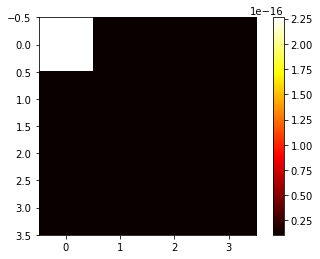

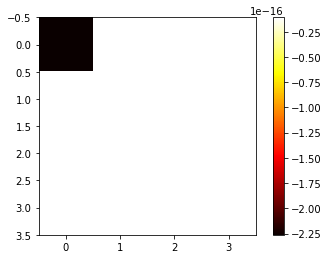

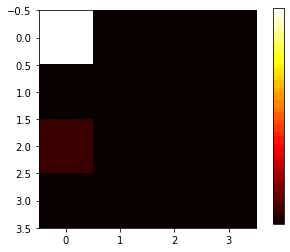

In [423]:
vec = eig[:, 0].reshape((Ls, Ls, n_bands, n_bands))[..., 0, 1].flatten()
import matplotlib.pyplot as plt

maxelem = 1.#vec[np.argmax(np.abs(vec))]
print(maxelem)
plt.imshow(np.abs(vec / maxelem).reshape((Ls, Ls)), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

import matplotlib.pyplot as plt
plt.imshow(np.real(vec / maxelem).reshape((Ls, Ls)), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

import matplotlib.pyplot as plt
plt.imshow(np.imag(vec / maxelem).reshape((Ls, Ls)), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [424]:
vals = []

gaps_realspace = []
for j in range(6):
    vec = eig[:, j].reshape((Ls ** 2, n_bands, n_bands))

    gap_matrix = np.zeros((Ls ** 2 * n_bands, Ls ** 2 * n_bands), dtype=np.complex128)
    for i in range(Ls ** 2):
        gap_matrix[i * n_bands:i * n_bands + n_bands, \
                   i * n_bands:i * n_bands + n_bands] = vec[i, ...]

    gap_relspace = fft.dot(gap_matrix).dot(fft.conj().T)
    gaps_realspace.append(gap_relspace * 1.)
    print(gap_relspace[:4, :4])
    print(np.vdot(gap_relspace.flatten(), gap_relspace.flatten()) * 16)
    vals.append(np.vdot(gap_relspace.flatten(), mapping.dot(gap_relspace).dot(mapping.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()))
    print(E[j], np.vdot(gap_relspace.flatten(), mapping.dot(mapping).dot(gap_relspace).dot(mapping.dot(mapping).T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()),
                np.vdot(gap_relspace.flatten(), mapping.dot(gap_relspace).dot(mapping.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()),
                np.vdot(gap_relspace.flatten(), Tx.dot(gap_relspace).dot(Tx.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()),
                np.vdot(gap_relspace.flatten(), Ty.dot(gap_relspace).dot(Ty.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()))
    #print(np.sum(np.abs(gap_relspace[:4, :4] - gap_relspace[4:8, 4:8])))
print(sum(vals[:2]), np.exp(2.0j * np.pi / 3.))
print('----------')
print(gaps_realspace[0][:4, :4] + gaps_realspace[1][:4, :4])

[[ 4.41941738e-02+1.43842893e-33j -6.05803644e-18-4.34034737e-20j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 5.03486082e-19-4.34034737e-20j -3.57005065e-33+9.34396679e-36j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  -4.41941738e-02+4.43808973e-19j  3.47965287e-18+1.56966472e-19j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   6.94874275e-19+1.56966472e-19j  3.17601271e-33-1.66096824e-35j]]
(1.0000000000000007+0j)
2072.7809411397902 (-0.49999999999999906-0.8660254037844389j) (-0.5000000000000003+0.8660254037844383j) (1+1.9259299443872346e-34j) (0.9999999999999998+3.851859888774469e-34j)
[[ 9.85937520e-04+2.52372421e-04j  1.13653531e-16-5.53989242e-18j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [-3.70061955e-18-2.60190815e-17j  4.41824539e-02+2.98393307e-18j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 

In [395]:
green = green.reshape((Ls ** 2, n_bands, n_bands))

green_matrix = np.zeros((Ls ** 2 * n_bands, Ls ** 2 * n_bands), dtype=np.complex128)

for i in range(Ls ** 2):
    green_matrix[i * n_bands:i * n_bands + n_bands, \
                 i * n_bands:i * n_bands + n_bands] = green[i, ...]

green_relspace = fft.dot(green_matrix).dot(fft.conj().T)
print(np.dot(green_relspace.conj().flatten(), mapping.dot(green_relspace).dot(mapping.T.conj()).flatten()) / np.dot(green_relspace.conj().flatten(), green_relspace.flatten()))
print(np.dot(green_relspace.conj().flatten(), Tx.dot(green_relspace).dot(Tx.T.conj()).flatten()) / np.dot(green_relspace.conj().flatten(), green_relspace.flatten()))
print(np.dot(green_relspace.conj().flatten(), Ty.dot(green_relspace).dot(Ty.T.conj()).flatten()) / np.dot(green_relspace.conj().flatten(), green_relspace.flatten()))

(0.9999999999999999-1.0333909192713865e-18j)
(1+9.13483041549566e-22j)
(0.9999999999999999+3.321898667375639e-22j)


In [127]:
print(np.sum(np.abs(gap_relspace[:4, 8:12] - gap_relspace[4:8, 12:16])))
print(np.dot(gap_relspace.conj().flatten(), gap_relspace.dot(mapping).flatten()))

1.3975966494472204e-17
(-0.013075451755622735+0.010374426776838214j)


In [ ]:
Alat[1] @ G[0] / 2 / np.pi